# Imporing required libraries 

In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import sklearn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from xgboost import XGBRegressor
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import os

# Any results you write to the current directory are saved as output.

Loading data

In [38]:
train=pd.read_csv('/kaggle/input/covid19-global-forecasting-week-1/train.csv')
test=pd.read_csv('/kaggle/input/covid19-global-forecasting-week-1/test.csv')
subm=pd.read_csv('/kaggle/input/covid19-global-forecasting-week-1/submission.csv')

Checking for null values

In [39]:
train.isnull().sum()

Id                   0
Province/State    9702
Country/Region       0
Lat                  0
Long                 0
Date                 0
ConfirmedCases       0
Fatalities           0
dtype: int64

In [40]:
train=train.drop(['Province/State'],axis=1) #since many null values in this column
test=test.drop(['Province/State'],axis=1)

# Feature engineering and feature generation


In [41]:
# calculating total confirmed cases in a country
e = train.groupby(['Country/Region','Lat','Long']).agg({'ConfirmedCases': ['sum']}) 
e.columns = ['confirmed_country']
e.reset_index(inplace=True)

In [42]:
 # merge generated feature to train
cols=['Country/Region','Lat','Long']      
train = pd.merge(train,e, on=cols, how='left')
train['confirmed_country'] = (train['confirmed_country'].fillna(0).astype(np.float16)) 

In [43]:
#calculating total fatalities in a country
f = train.groupby(['Country/Region','Lat','Long']).agg({'Fatalities': ['sum']}) 
f.columns = ['fatalities_country']
f.reset_index(inplace=True)

In [44]:
# merge generated feature to train
cols=['Country/Region','Lat','Long']
train = pd.merge(train,f, on=cols, how='left')
train['fatalities_country'] = (train['fatalities_country'].fillna(0).astype(np.float16)) 

In [45]:
train.head()  

,Id,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,confirmed_country,fatalities_country
0,1,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0,363.0,3.0
1,2,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0,363.0,3.0
2,3,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0,363.0,3.0
3,4,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0,363.0,3.0
4,5,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0,363.0,3.0


In [46]:
#target variables
Y1=train['ConfirmedCases']
Y2=train['Fatalities']
train=train.drop(['ConfirmedCases'],axis=1)
train=train.drop(['Fatalities'],axis=1)

In [47]:
# ID feature does not provide any useful information
train=train.drop(['Id'],axis=1)
test=test.drop(['ForecastId'],axis=1)

In [48]:
# Concatenating train and test data for further preprocessing
data = pd.concat([train, test], ignore_index=True, sort=False, keys=cols)
data.fillna(0, inplace=True) # 34 mont

In [49]:
# Generating month and day feature
data['split'] = data['Date'].str.split('-')
data['Month'] = data['split'].map(lambda x: x[1].strip())
data['day'] = data['split'].map(lambda x: x[2].strip())
data=data.drop(['split'],axis=1)

In [50]:
# Combining latitude and longitude features to form location(coordinate) feature 
data['location'] = data.apply(lambda row: (row.Lat , row.Long), axis=1)

In [51]:
#converting to standard datetime format of pandas
data['Date']= pd.to_datetime(data['Date'])

In [52]:
#day of week
data['weekday']=data['Date'].dt.weekday_name


In [53]:
# convert location datatype to string
data.location = data.location.astype('str') 

In [54]:
# Encoding features to numerical form
data['Country/Region_code']=LabelEncoder().fit_transform(data['Country/Region'])
data['Date_code']=LabelEncoder().fit_transform(data['Date'])
data['location_code']=LabelEncoder().fit_transform(data['location'])
data['weekday_code']=LabelEncoder().fit_transform(data['weekday'])

In [55]:
data=data.drop(['Country/Region'],axis=1)
data=data.drop(['Date'],axis=1)
data=data.drop(['location'],axis=1)
data=data.drop(['weekday'],axis=1)

In [56]:
data

,Lat,Long,confirmed_country,fatalities_country,Month,day,Country/Region_code,Date_code,location_code,weekday_code
0,33.0000,65.0000,363.0,3.0,01,22,0,0,122,6
1,33.0000,65.0000,363.0,3.0,01,23,0,1,122,4
2,33.0000,65.0000,363.0,3.0,01,24,0,2,122,0
3,33.0000,65.0000,363.0,3.0,01,25,0,3,122,2
4,33.0000,65.0000,363.0,3.0,01,26,0,4,122,3
...,...,...,...,...,...,...,...,...,...,...
30099,-15.4167,28.2833,0.0,0.0,04,19,162,88,9,3
30100,-15.4167,28.2833,0.0,0.0,04,20,162,89,9,1
30101,-15.4167,28.2833,0.0,0.0,04,21,162,90,9,5
30102,-15.4167,28.2833,0.0,0.0,04,22,162,91,9,6


In [57]:
#Month and day feature as integer 
data.Month=data.Month.astype('int64')
data.day=data.day.astype('int64')

In [58]:
# difference between confirmed cases and fatalities
data['diff']=data['confirmed_country']-data['fatalities_country']

In [59]:
data.head()

,Lat,Long,confirmed_country,fatalities_country,Month,day,Country/Region_code,Date_code,location_code,weekday_code,diff
0,33.0,65.0,363.0,3.0,1,22,0,0,122,6,360.0
1,33.0,65.0,363.0,3.0,1,23,0,1,122,4,360.0
2,33.0,65.0,363.0,3.0,1,24,0,2,122,0,360.0
3,33.0,65.0,363.0,3.0,1,25,0,3,122,2,360.0
4,33.0,65.0,363.0,3.0,1,26,0,4,122,3,360.0


In [64]:
length = len(Y1)

In [65]:
# splitting training and test data
X_train = data[0:(length-400)]
Y_train = Y1[0:(length-400)]
X_valid=data[(length-400):length]
Y_valid=Y1[(length-400):length]
X_test = data[length:]

In [67]:
len(Y_train)

17492

In [70]:
#Hyperparameter tuning using grid search 
parameters = {"max_depth": [ 3,5],'learning_rate':[0.13,0.15],'n_estimators':[10,100]}
model1=XGBRegressor(eval_metric='rmsle')
clf = GridSearchCV(model1, param_grid=parameters)
clf.fit(X_train,Y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, eval_metric='rmsle',
                                    gamma=None, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_co...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
         

In [71]:
clf.best_params_

{'learning_rate': 0.13, 'max_depth': 5, 'n_estimators': 100}

In [72]:
# fitting XGBoost with best parameters
model1=XGBRegressor(max_depth=5,learning_rate=0.13,n_estimators=100,eval_metric='rmsle')


model1.fit(X_train, Y_train, eval_metric="rmsle", eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=True, early_stopping_rounds = 10)

[0]	validation_0-rmsle:1.72783	validation_1-rmsle:1.59232
Multiple eval metrics have been passed: 'validation_1-rmsle' will be used for early stopping.

Will train until validation_1-rmsle hasn't improved in 10 rounds.
[1]	validation_0-rmsle:1.76313	validation_1-rmsle:1.72422
[2]	validation_0-rmsle:1.91075	validation_1-rmsle:1.93631
[3]	validation_0-rmsle:1.92656	validation_1-rmsle:1.95743
[4]	validation_0-rmsle:1.93314	validation_1-rmsle:1.95862
[5]	validation_0-rmsle:1.92261	validation_1-rmsle:1.87028
[6]	validation_0-rmsle:1.90796	validation_1-rmsle:1.84800
[7]	validation_0-rmsle:1.94080	validation_1-rmsle:1.88366
[8]	validation_0-rmsle:1.89241	validation_1-rmsle:1.79197
[9]	validation_0-rmsle:1.94329	validation_1-rmsle:1.85909
[10]	validation_0-rmsle:1.91058	validation_1-rmsle:1.76755
Stopping. Best iteration:
[0]	validation_0-rmsle:1.72783	validation_1-rmsle:1.59232



XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmsle',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.13, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [74]:
print(model1.feature_importances_)

[0.06929774 0.00860552 0.01169637 0.7900022  0.00235929 0.00436998
 0.         0.11366892 0.         0.         0.        ]


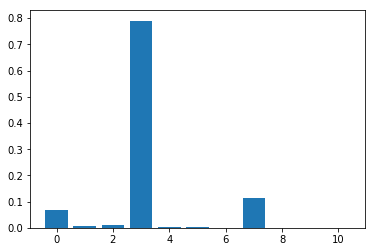

In [75]:
plt.bar(range(len(model1.feature_importances_)), model1.feature_importances_)
plt.show()

In [94]:
#choosing most important features
xtrain=X_train[['Lat','confirmed_country','fatalities_country','Country/Region_code','Date_code']]
xvalid=X_valid[['Lat','confirmed_country','fatalities_country','Country/Region_code','Date_code']]
xtest1=X_test[['Lat','confirmed_country','fatalities_country','Country/Region_code','Date_code']]
model1.fit(xtrain, Y_train, eval_metric="rmsle", eval_set=[(xtrain, Y_train), (xvalid, Y_valid)], verbose=True, early_stopping_rounds = 10)


[0]	validation_0-rmsle:1.72783	validation_1-rmsle:1.59232
Multiple eval metrics have been passed: 'validation_1-rmsle' will be used for early stopping.

Will train until validation_1-rmsle hasn't improved in 10 rounds.
[1]	validation_0-rmsle:1.76313	validation_1-rmsle:1.72422
[2]	validation_0-rmsle:1.91075	validation_1-rmsle:1.93631
[3]	validation_0-rmsle:1.92656	validation_1-rmsle:1.95743
[4]	validation_0-rmsle:1.93320	validation_1-rmsle:1.97268
[5]	validation_0-rmsle:1.92272	validation_1-rmsle:1.88496
[6]	validation_0-rmsle:1.97214	validation_1-rmsle:1.94908
[7]	validation_0-rmsle:1.94699	validation_1-rmsle:1.86366
[8]	validation_0-rmsle:1.93665	validation_1-rmsle:1.87793
[9]	validation_0-rmsle:1.91676	validation_1-rmsle:1.82707
[10]	validation_0-rmsle:1.90245	validation_1-rmsle:1.80828
Stopping. Best iteration:
[0]	validation_0-rmsle:1.72783	validation_1-rmsle:1.59232



XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmsle',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.13, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [81]:
length=len(Y2)

In [84]:
Y_train2 = Y2[0:(length-400)]
Y_valid2 = Y2[(length-400):length]

In [86]:
parameters = {"max_depth": [ 4,5],'learning_rate':[0.14,0.15],'n_estimators':[50,100]}
model2=XGBRegressor(eval_metric='rmsle')
clf1 = GridSearchCV(model2, param_grid=parameters)
clf1.fit(X_train,Y_train2)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, eval_metric='rmsle',
                                    gamma=None, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_co...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
         

In [87]:
clf1.best_params_

{'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 100}

In [88]:
model2 = XGBRegressor(learning_rate= 0.15, max_depth= 5, n_estimators= 100)


model2.fit(X_train, Y_train2, eval_metric="rmsle", eval_set=[(X_train, Y_train2), (X_valid, Y_valid2)], verbose=True, early_stopping_rounds = 10)

[0]	validation_0-rmsle:0.63386	validation_1-rmsle:0.68672
Multiple eval metrics have been passed: 'validation_1-rmsle' will be used for early stopping.

Will train until validation_1-rmsle hasn't improved in 10 rounds.
[1]	validation_0-rmsle:0.63470	validation_1-rmsle:0.76019
[2]	validation_0-rmsle:0.58063	validation_1-rmsle:0.75991
[3]	validation_0-rmsle:0.55120	validation_1-rmsle:0.71356
[4]	validation_0-rmsle:0.53301	validation_1-rmsle:0.69537
[5]	validation_0-rmsle:0.52063	validation_1-rmsle:0.68995
[6]	validation_0-rmsle:0.49753	validation_1-rmsle:0.67307
[7]	validation_0-rmsle:0.48202	validation_1-rmsle:0.66489
[8]	validation_0-rmsle:0.47383	validation_1-rmsle:0.65430
[9]	validation_0-rmsle:0.46898	validation_1-rmsle:0.65893
[10]	validation_0-rmsle:0.45976	validation_1-rmsle:0.65580
[11]	validation_0-rmsle:0.44645	validation_1-rmsle:0.63732
[12]	validation_0-rmsle:0.44549	validation_1-rmsle:0.64347
[13]	validation_0-rmsle:nan	validation_1-rmsle:0.64548
[14]	validation_0-rmsle:nan

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.15, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

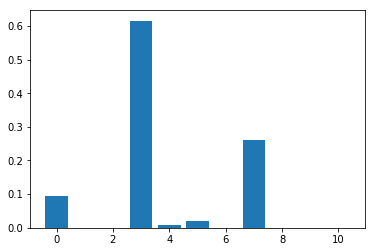

In [89]:
plt.bar(range(len(model2.feature_importances_)), model2.feature_importances_)
plt.show()

In [93]:
#choosing most important features
xtrain=X_train[['Lat','fatalities_country', 'Month','day','Date_code']]
xvalid=X_valid[['Lat','fatalities_country', 'Month','day','Date_code']]
xtest2=X_test[['Lat','fatalities_country', 'Month','day','Date_code']]
model2.fit(xtrain, Y_train2, eval_metric="rmsle", eval_set=[(xtrain, Y_train2), (xvalid, Y_valid2)], verbose=True, early_stopping_rounds = 10)

[0]	validation_0-rmsle:0.63386	validation_1-rmsle:0.68672
Multiple eval metrics have been passed: 'validation_1-rmsle' will be used for early stopping.

Will train until validation_1-rmsle hasn't improved in 10 rounds.
[1]	validation_0-rmsle:0.63470	validation_1-rmsle:0.76019
[2]	validation_0-rmsle:0.58063	validation_1-rmsle:0.75991
[3]	validation_0-rmsle:0.55120	validation_1-rmsle:0.72192
[4]	validation_0-rmsle:0.53301	validation_1-rmsle:0.69978
[5]	validation_0-rmsle:0.52063	validation_1-rmsle:0.69261
[6]	validation_0-rmsle:0.49758	validation_1-rmsle:0.67424
[7]	validation_0-rmsle:0.49186	validation_1-rmsle:0.68054
[8]	validation_0-rmsle:0.47541	validation_1-rmsle:0.65601
[9]	validation_0-rmsle:0.45873	validation_1-rmsle:0.64024
[10]	validation_0-rmsle:0.45509	validation_1-rmsle:0.64142
[11]	validation_0-rmsle:0.44485	validation_1-rmsle:0.63437
[12]	validation_0-rmsle:0.44111	validation_1-rmsle:0.62895
[13]	validation_0-rmsle:nan	validation_1-rmsle:0.61858
[14]	validation_0-rmsle:nan

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.15, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [95]:
#Confirmed cases 
pred1=model1.predict(xtest1)

In [96]:
#Fatalities
pred2=model2.predict(xtest2)

In [98]:
#final csv file
subm['ConfirmedCases']=pred1
subm['Fatalities']=pred2
subm.ConfirmedCases=subm.ConfirmedCases.astype('int64')
subm.Fatalities=subm.Fatalities.astype('int64')
subm.to_csv('final_file.csv',index=False,columns=['ForecastId','ConfirmedCases','Fatalities'])